${\Huge \text{Feature engineering (Random Forest) - artefact classification}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook aims to compare different set of features (without a group, new features, ...) with a given algorithm (GradientBoosting), to perform artefact vs somatic mutations classification.

This notebook is divided in 6 parts:
* **1. Get the data**
* **2. Baseline**
* **3. Removing one group**
* **4. Without gnomAD populations**
* **5. VEP gnomAD_AF vs Pierre gnomAD_AF**
* **6. New features**
* **7. Conclusion**

***

In [1]:
%run ../../../utils/Python/setup_environment.ipy
%run ../../../utils/Python/selene_job.ipy

Selene_Job.cluster_username             = 'guilminp'
Selene_Job.ssh_remote_jobs_cluster_path = '/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs'
Selene_Job.ssh_remote_jobs_local_path   = 'ssh_remote_jobs'

Setup environment... done!


<span style="color:green">✅ Working on **imp-ann_env** conda environment.</span>

# Get the data

In [2]:
data = Impact_Wrapper('../../../data/processed/annotated_final_IMPACT_mutations_20181105.txt', 'is_artefact')
data.impact.shape

(225022, 57)

In [3]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_VARIANT_CLASS'],

    'freq': ['frequency_in_normals'],

    'somatic-driver': ['VEP_COSMIC_CNT',
                       'is_a_hotspot', 'is_a_3d_hotspot', 'oncogenic'],

    'consequence': ['gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'VEP_in_dbSNP'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = unlist([group for key, group in features_groups.items() if key not in groups_to_remove])
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove redundant values
    return list(set(final_selection))

# Baseline

In [4]:
features = get_features()
X, y = data.process(features).get_X_and_y('all', 'all')

job_baseline = Selene_Job('ferf_baseline')
job_baseline.load_data(X, y)

<span style="color:red">Job < ferf_baseline >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_baseline


<span style="color:green">Job < ferf_baseline >: </span>✅ data loaded

In [5]:
job_baseline = Selene_Job('ferf_baseline', 'guilminp', '/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs', 'ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < ferf_baseline >: </span>✅ job found and reloaded

In [6]:
%%writefile {job_baseline.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# set cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=42, criterion='entropy', max_depth=20, n_estimators=500))

metrics = Metrics(model, X, y, cv_strategy, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_ferf_baseline/script.ipy


In [7]:
job_baseline.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_ferf_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_baseline
script.ipy                                    100%  862   104.8KB/s   00:00    
X.pkl                                         100%   72MB  13.5MB/s   00:05    
y.pkl                                         100% 3736KB  16.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_baseline
Job <30747935> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_baseline -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_baseline >: </span>✅ submitted<br>

In [8]:
job_baseline.get_results()

<span style="color:red">Job < ferf_baseline >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.514 ± 0.015
▴ Mean roc_auc          : 0.900 ± 0.005
▴ Mean precision        : 0.166 ± 0.004
▴ Mean recall           : 0.758 ± 0.012
▴ Mean f1               : 0.273 ± 0.006
▴ Mean accuracy         : 0.877 ± 0.004


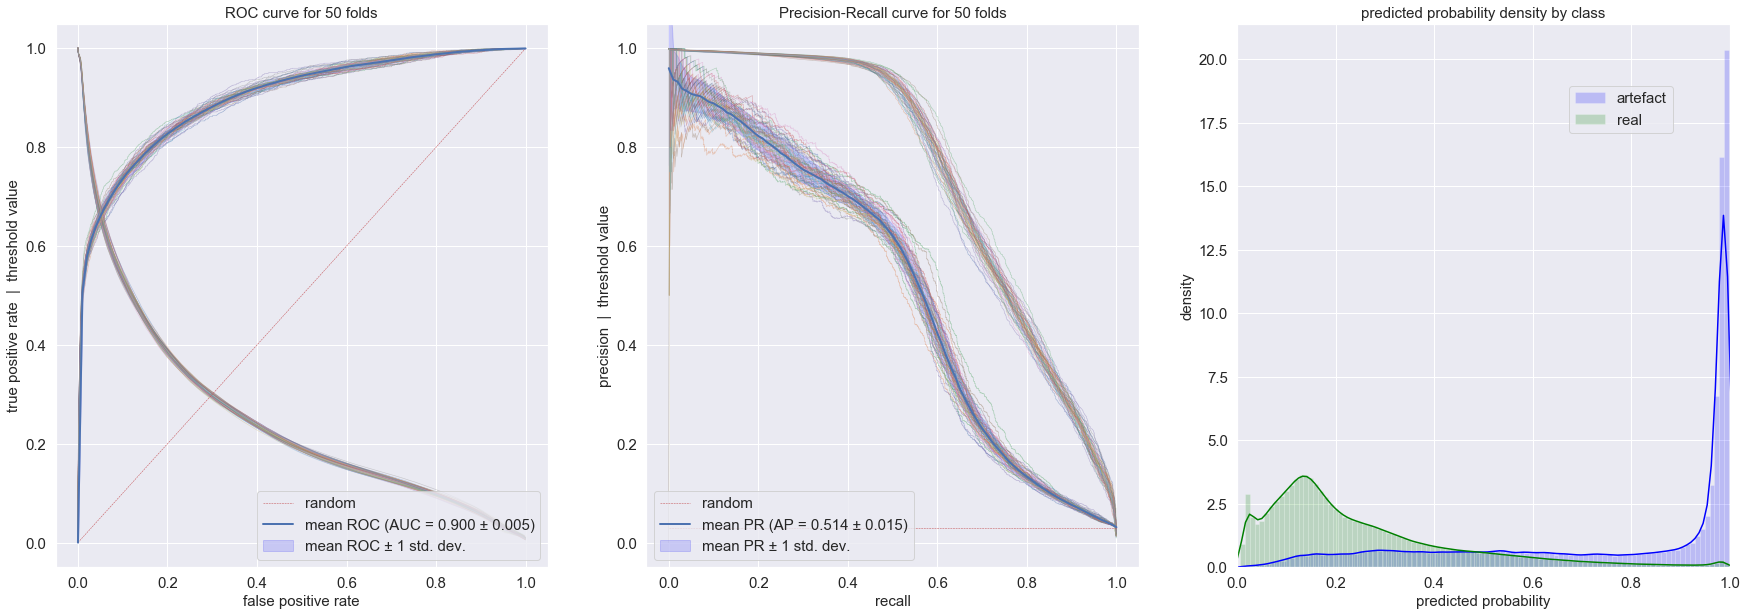

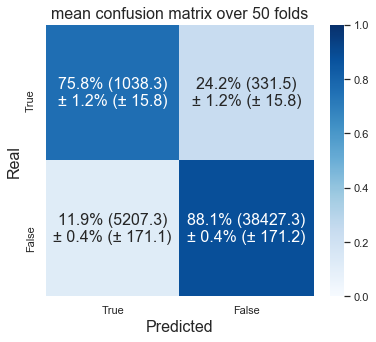

In [36]:
job_baseline.metrics.print_mean()
job_baseline.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_baseline.metrics.plot_mean_confusion_matrix()

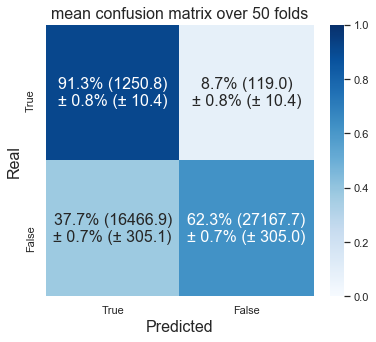

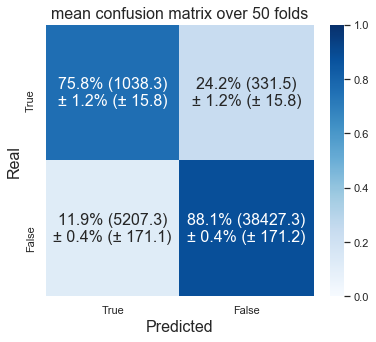

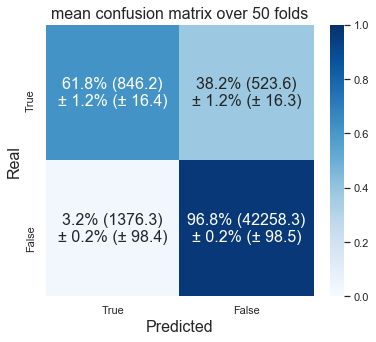

In [37]:
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.25)
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.5)
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.75)

# Removing one group

In [9]:
job_list = {}

for group in features_groups.keys():
    name = 'without_{}'.format(group)
    print_md('**{}**'.format(name))
    
    job_list[name] = Selene_Job('ferf_{}'.format(name))
    
    # get X and y
    print('Get X and y...', end= '')
    start = time.time()
    features = get_features(groups_to_remove = [group])
    X, y = data.process(features).get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} raw features, {} features after processing)'.format(time.time() - start, len(features), X.shape[1]))
    
    # prepare job
    job_list[name].load_data(X, y, path_to_script=job_baseline.script_path)

**without_NGS**

<span style="color:red">Job < ferf_without_NGS >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (13.52s, 24 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_NGS


<span style="color:green">Job < ferf_without_NGS >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_NGS


<span style="color:green">Job < ferf_without_NGS >: </span>✅ script loaded

**without_genome**

<span style="color:red">Job < ferf_without_genome >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (11.53s, 33 raw features, 62 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_genome


<span style="color:green">Job < ferf_without_genome >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_genome


<span style="color:green">Job < ferf_without_genome >: </span>✅ script loaded

**without_freq**

<span style="color:red">Job < ferf_without_freq >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (14.65s, 34 raw features, 90 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_freq


<span style="color:green">Job < ferf_without_freq >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_freq


<span style="color:green">Job < ferf_without_freq >: </span>✅ script loaded

**without_somatic-driver**

<span style="color:red">Job < ferf_without_somatic-driver >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (11.29s, 31 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_somatic-driver


<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_somatic-driver


<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ script loaded

**without_consequence**

<span style="color:red">Job < ferf_without_consequence >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (8.87s, 29 raw features, 64 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_consequence


<span style="color:green">Job < ferf_without_consequence >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_consequence


<span style="color:green">Job < ferf_without_consequence >: </span>✅ script loaded

**without_AF**

<span style="color:red">Job < ferf_without_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (14.61s, 24 raw features, 79 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_AF


<span style="color:green">Job < ferf_without_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_AF


<span style="color:green">Job < ferf_without_AF >: </span>✅ script loaded

In [10]:
job_list = {}
for group in features_groups.keys():
    name = 'without_{}'.format(group)
    job_list[name] = Selene_Job('ferf_{}'.format(name), load_from_id=True)

<span style="color:green">Job < ferf_without_NGS >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_genome >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_freq >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_consequence >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_AF >: </span>✅ job found and reloaded

In [11]:
for job in job_list.values():
    print_md('**{}**'.format(job.job_id))
    job.run(n_jobs=20, short_job=True)

**ferf_without_NGS**

➞ scp ssh_remote_jobs/job_ferf_without_NGS to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_NGS
script.ipy                                    100%  862    94.7KB/s   00:00    
X.pkl                                         100%   53MB  14.6MB/s   00:03    
y.pkl                                         100% 3736KB  13.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_NGS
Job <30747947> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_NGS -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_NGS >: </span>✅ submitted<br>

**ferf_without_genome**

➞ scp ssh_remote_jobs/job_ferf_without_genome to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_genome
script.ipy                                    100%  862    85.2KB/s   00:00    
X.pkl                                         100%   67MB  14.9MB/s   00:04    
y.pkl                                         100% 3736KB  15.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_genome
Job <30747948> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_genome -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_genome >: </span>✅ submitted<br>

**ferf_without_freq**

➞ scp ssh_remote_jobs/job_ferf_without_freq to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_freq
script.ipy                                    100%  862    98.8KB/s   00:00    
X.pkl                                         100%   70MB  14.1MB/s   00:05    
y.pkl                                         100% 3736KB  12.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_freq
Job <30747949> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_freq -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_freq >: </span>✅ submitted<br>

**ferf_without_somatic-driver**

➞ scp ssh_remote_jobs/job_ferf_without_somatic-driver to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_somatic-driver
script.ipy                                    100%  862   136.2KB/s   00:00    
X.pkl                                         100%   63MB  10.4MB/s   00:06    
y.pkl                                         100% 3736KB  13.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_somatic-driver
Job <30747950> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_somatic-driver -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ submitted<br>

**ferf_without_consequence**

➞ scp ssh_remote_jobs/job_ferf_without_consequence to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_consequence
script.ipy                                    100%  862   108.6KB/s   00:00    
X.pkl                                         100%   57MB  14.1MB/s   00:04    
y.pkl                                         100% 3736KB  16.7MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_consequence
Job <30747951> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_consequence -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_consequence >: </span>✅ submitted<br>

**ferf_without_AF**

➞ scp ssh_remote_jobs/job_ferf_without_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_AF
script.ipy                                    100%  862   151.6KB/s   00:00    
X.pkl                                         100%   52MB  16.0MB/s   00:03    
y.pkl                                         100% 3736KB  15.7MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_AF
Job <30747953> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_AF >: </span>✅ submitted<br>

In [12]:
for job in job_list.values():
    print_md('**{}**'.format(job.job_id))
    job.get_results()

**ferf_without_NGS**

<span style="color:red">Job < ferf_without_NGS >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**ferf_without_genome**

<span style="color:red">Job < ferf_without_genome >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**ferf_without_freq**

<span style="color:red">Job < ferf_without_freq >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**ferf_without_somatic-driver**

<span style="color:red">Job < ferf_without_somatic-driver >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**ferf_without_consequence**

<span style="color:red">Job < ferf_without_consequence >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

**ferf_without_AF**

<span style="color:red">Job < ferf_without_AF >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
without_NGS,0.386,0.836,0.108,0.688,0.187,0.817
without_genome,0.504,0.887,0.161,0.736,0.265,0.876
without_freq,0.487,0.894,0.156,0.754,0.259,0.868
without_somatic-driver,0.511,0.893,0.17,0.741,0.276,0.882
without_consequence,0.503,0.888,0.161,0.743,0.265,0.874
without_AF,0.496,0.895,0.163,0.751,0.268,0.875


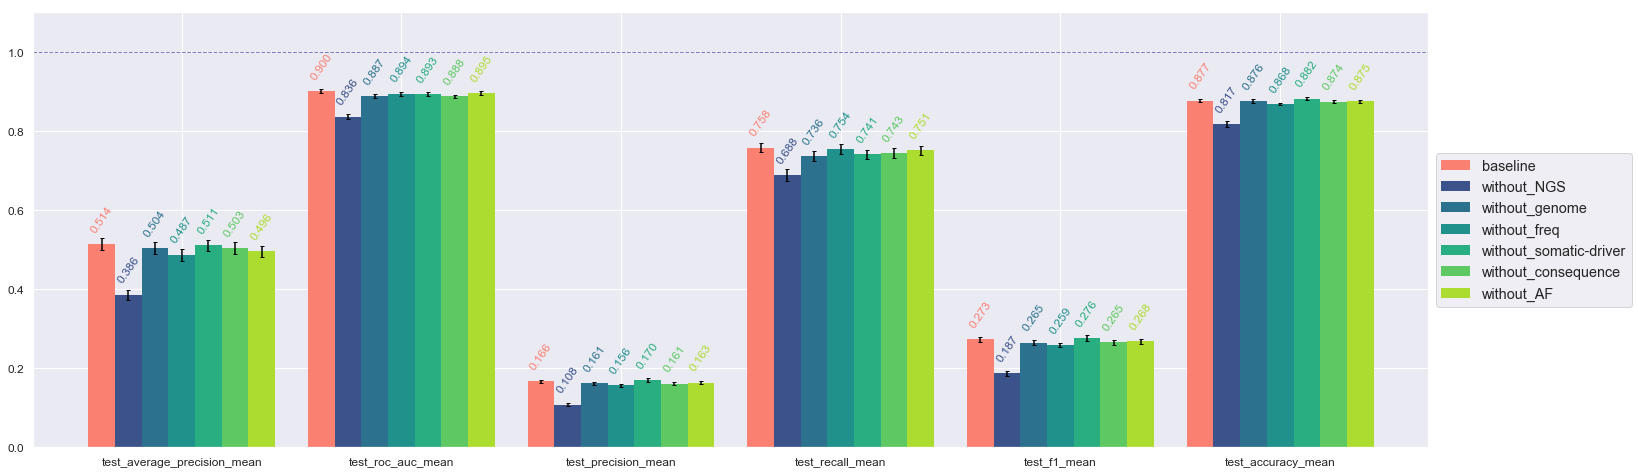

In [40]:
# create summary
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')

# fill summary
for key in job_list:
    summary.add(job_list[key].metrics, key)

# save summary
#summary.save('summaries/fe_without_one_group.pkl')

# plot summary
summary.display()
summary.plot()

# Without gnomAD populations

In [13]:
features = get_features(individual_features_to_remove = AF_populations)
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_without_gnomAD_populations')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_without_gnomAD_populations >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_gnomAD_populations


<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_gnomAD_populations


<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ script loaded

In [14]:
job = Selene_Job('ferf_without_gnomAD_populations', load_from_id=True)

<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ job found and reloaded

In [15]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_ferf_without_gnomAD_populations to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_gnomAD_populations
script.ipy                                    100%  862   114.9KB/s   00:00    
X.pkl                                         100%   60MB  12.0MB/s   00:05    
y.pkl                                         100% 3736KB  14.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_without_gnomAD_populations
Job <30747956> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_gnomAD_populations -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ submitted<br>

In [16]:
job.get_results()

<span style="color:red">Job < ferf_without_gnomAD_populations >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
fe_without_gnomAD_populations,0.513,0.9,0.166,0.759,0.272,0.877


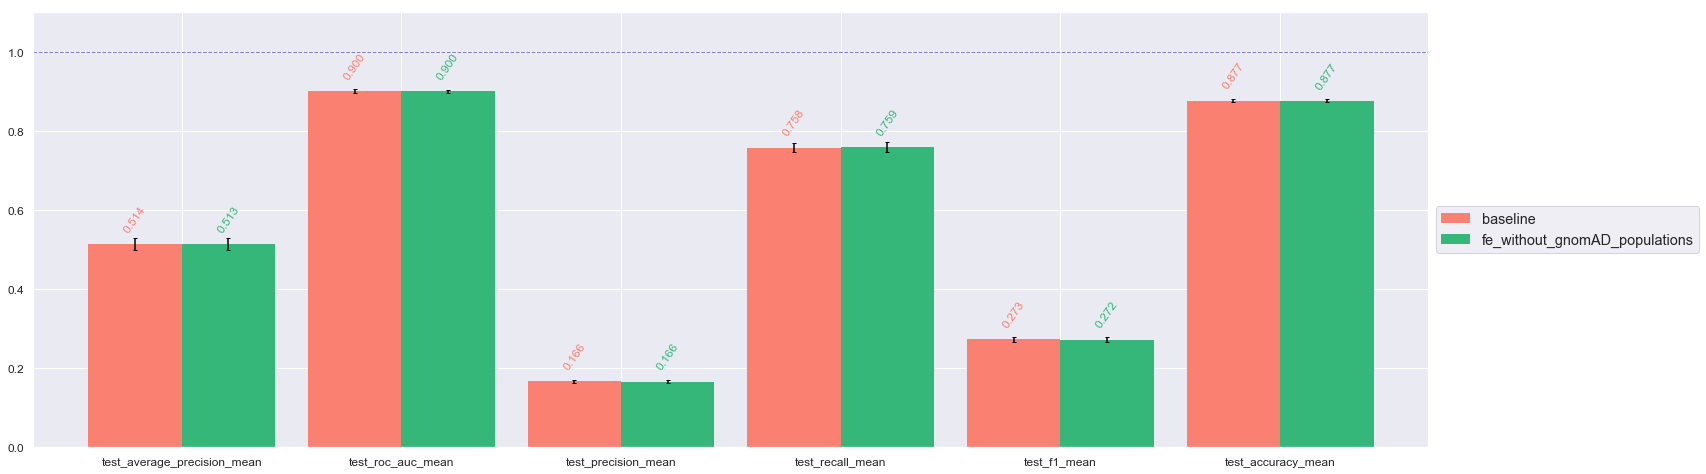

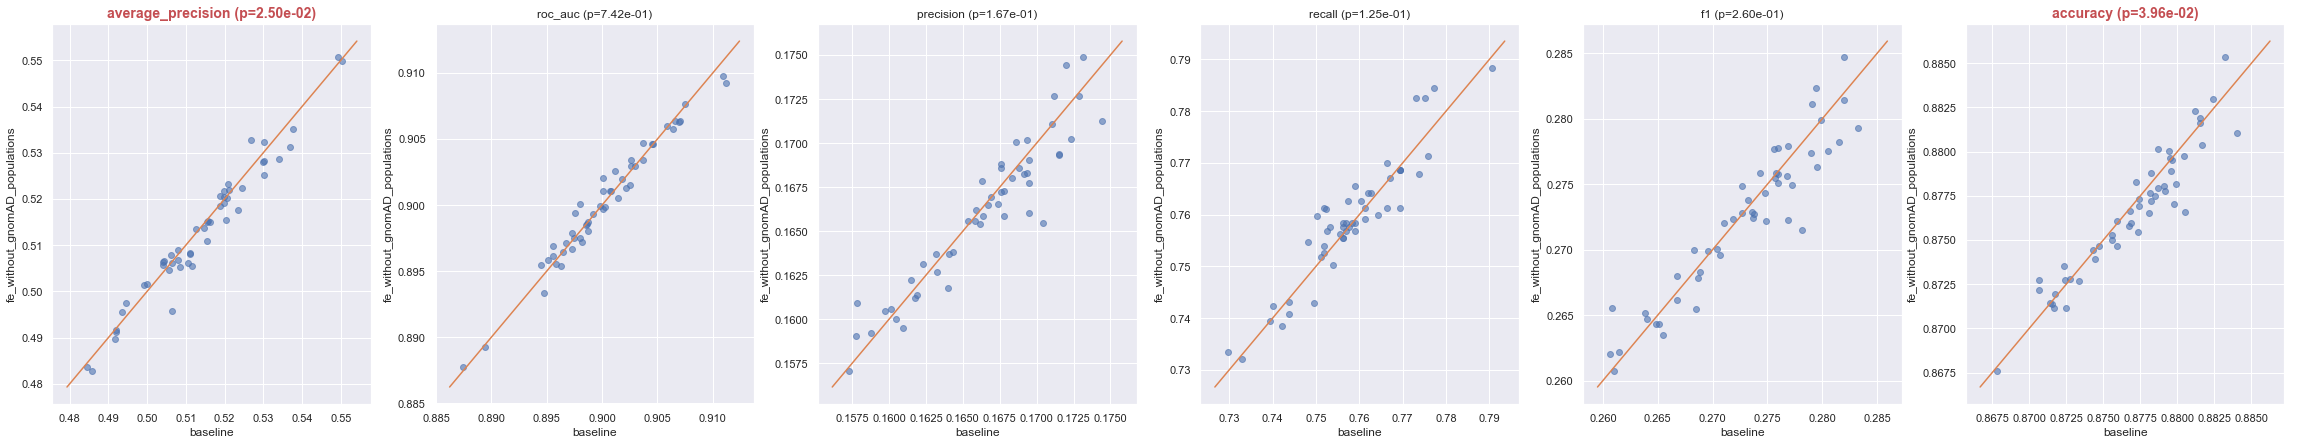

In [43]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)

summary.display()
summary.plot()
summary.plot_2_vs_2('baseline', job.job_id)

# VEP gnomAD_AF vs Pierre gnomAD_AF vs both

In [17]:
# without
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_1 = Selene_Job('fe_rf_no_gnomAD_AF')
job_1.load_data(X, y, path_to_script=job_baseline.script_path)

# VEP gnomAD_AF
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_total_AF'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_2 = Selene_Job('fe_rf_VEP_gnomAD_AF')
job_2.load_data(X, y, path_to_script=job_baseline.script_path)

# Pierre gnomAD_AF
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_AF'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_3 = Selene_Job('fe_rf_Pierre_gnomAD_AF')
job_3.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < fe_rf_no_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_rf_no_gnomAD_AF


<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_fe_rf_no_gnomAD_AF


<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ script loaded

<span style="color:red">Job < fe_rf_VEP_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF


<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF


<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ script loaded

<span style="color:red">Job < fe_rf_Pierre_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF


<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF


<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ script loaded

In [18]:
job_1 = Selene_Job('fe_rf_no_gnomAD_AF'    , load_from_id=True)
job_2 = Selene_Job('fe_rf_VEP_gnomAD_AF'   , load_from_id=True)
job_3 = Selene_Job('fe_rf_Pierre_gnomAD_AF', load_from_id=True)

<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ job found and reloaded

In [19]:
job_1.run(n_jobs=20, short_job=True)
job_2.run(n_jobs=20, short_job=True)
job_3.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_fe_rf_no_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fe_rf_no_gnomAD_AF
script.ipy                                    100%  862   108.4KB/s   00:00    
X.pkl                                         100%   57MB  15.0MB/s   00:03    
y.pkl                                         100% 3736KB  16.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fe_rf_no_gnomAD_AF
Job <30747958> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_rf_no_gnomAD_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ submitted<br>

➞ scp ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF
script.ipy                                    100%  862   107.1KB/s   00:00    
X.pkl                                         100%   58MB  11.7MB/s   00:05    
y.pkl                                         100% 3736KB   9.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF
Job <30747959> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_rf_VEP_gnomAD_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ submitted<br>

➞ scp ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF
script.ipy                                    100%  862    98.3KB/s   00:00    
X.pkl                                         100%   58MB  12.4MB/s   00:04    
y.pkl                                         100% 3736KB  12.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF
Job <30747960> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_rf_Pierre_gnomAD_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ submitted<br>

In [20]:
job_1.get_results()
job_2.get_results()
job_3.get_results()

<span style="color:red">Job < fe_rf_no_gnomAD_AF >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

<span style="color:red">Job < fe_rf_VEP_gnomAD_AF >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

<span style="color:red">Job < fe_rf_Pierre_gnomAD_AF >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [ ]:
summary_6 = Summary()

summary_6.add(job_baseline.metrics, 'baseline', 'salmon')
summary_6.add(job_1.metrics, job_1.job_id)
summary_6.add(job_2.metrics, job_2.job_id)
summary_6.add(job_3.metrics, job_3.job_id)

summary_6.display()
summary_6.plot()
# summary_6.plot_2_vs_2('baseline', job_3.job_id)
# summary_6.plot_2_vs_2('baseline', job_1.job_id)
# summary_6.plot_2_vs_2('baseline', job_2.job_id)
# summary_6.plot_2_vs_2(job_1.job_id, job_2.job_id)

# New features

## Number of non-null gnomAD population

In [21]:
dd = data.impact.apply(lambda x: sum(x[AF_populations] != 0), axis=1).astype(int)
get_table(dd)

,count_,freq_
0,180821,80.36%
1,24990,11.11%
2,8966,3.98%
3,4885,2.17%
4,2074,0.92%
7,1411,0.63%
5,1076,0.48%
6,799,0.36%


In [22]:
data.add_features('VEP_gnomAD_non_null_population_number', dd, False)

In [23]:
# seaborn.countplot(x='VEP_gnomAD_non_null_population_number', hue='is_artefact', dodge=False, data=data.impact)

In [24]:
features = get_features() + ['VEP_gnomAD_non_null_population_number']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_population_number')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_population_number >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_population_number


<span style="color:green">Job < ferf_with_population_number >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_population_number


<span style="color:green">Job < ferf_with_population_number >: </span>✅ script loaded

In [25]:
job = Selene_Job('ferf_with_population_number', load_from_id=True)

<span style="color:green">Job < ferf_with_population_number >: </span>✅ job found and reloaded

In [26]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_ferf_with_population_number to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_population_number
script.ipy                                    100%  862   140.7KB/s   00:00    
X.pkl                                         100%   74MB  14.8MB/s   00:04    
y.pkl                                         100% 3736KB  14.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_population_number
Job <30747978> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_population_number -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_population_number >: </span>✅ submitted<br>

In [27]:
job.get_results()

<span style="color:red">Job < ferf_with_population_number >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
fe_with_population_number,0.514,0.9,0.166,0.758,0.272,0.877


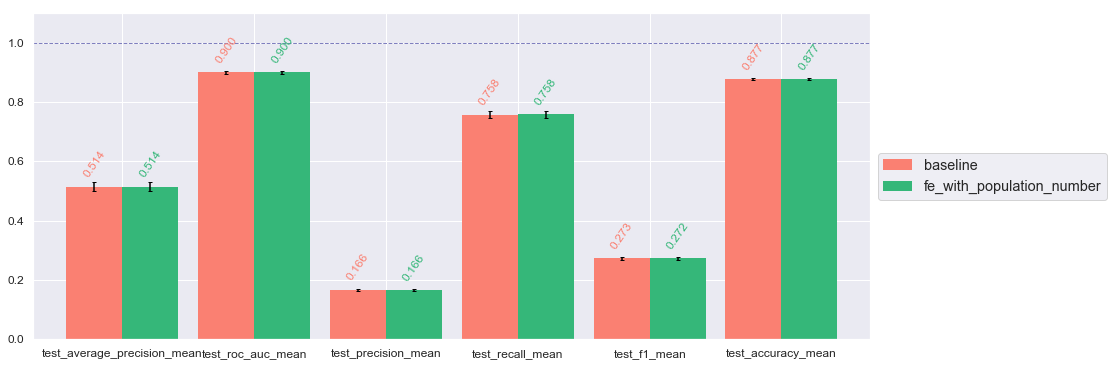

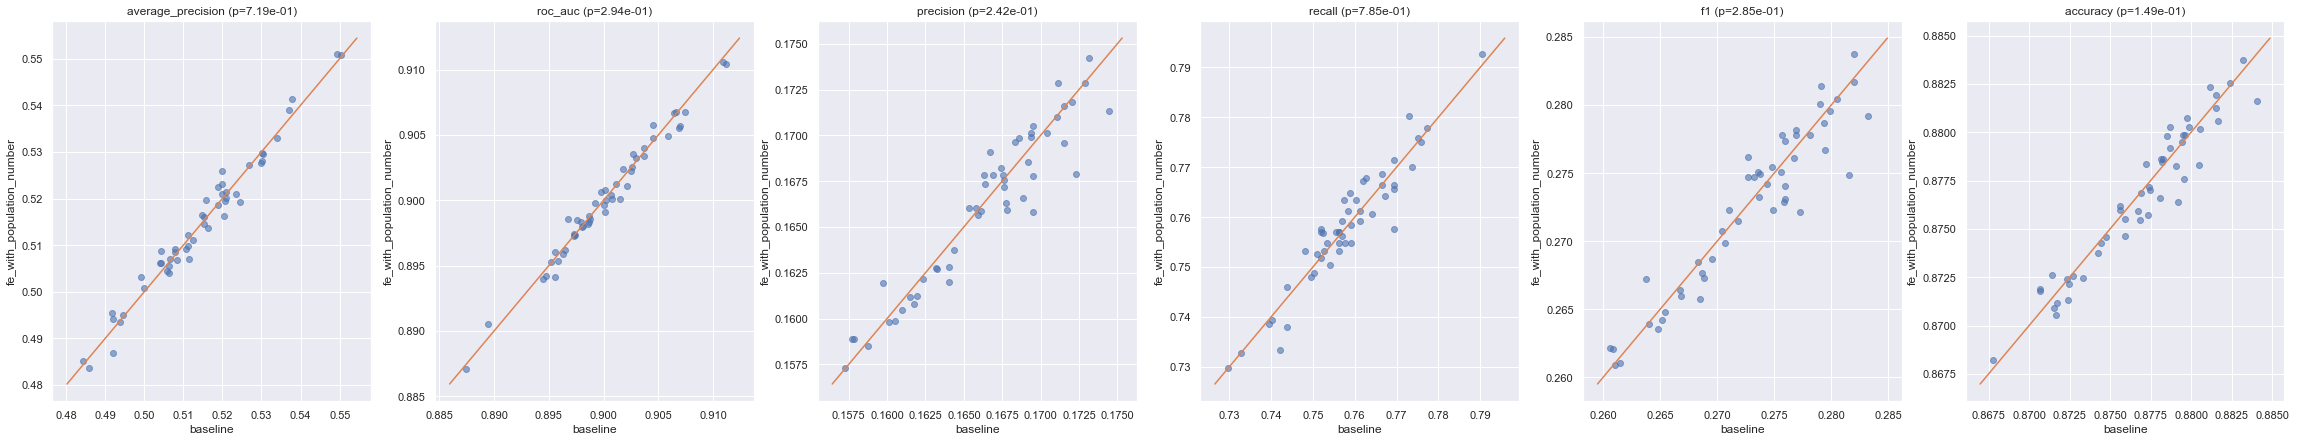

In [46]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)

summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## Strand ratio

In [28]:
dd = data.impact[['t_alt_neg_count', 't_alt_plus_count']].min(axis=1) / data.impact[['t_alt_neg_count', 't_alt_plus_count']].max(axis=1)
dd.head()

0    0.734694
1    0.791667
2    0.631579
3    0.583333
4    0.775000
dtype: float64

In [29]:
data.add_features('strand_ratio', dd, False)

In [30]:
features = get_features() + ['strand_ratio']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_strand_ratio')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_strand_ratio >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_strand_ratio


<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_strand_ratio


<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ script loaded

In [31]:
job = Selene_Job('ferf_with_strand_ratio', load_from_id=True)

<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ job found and reloaded

In [32]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_ferf_with_strand_ratio to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_strand_ratio
script.ipy                                    100%  862   102.1KB/s   00:00    
X.pkl                                         100%   74MB  15.5MB/s   00:04    
y.pkl                                         100% 3736KB  16.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_strand_ratio
Job <30747979> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_strand_ratio -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ submitted<br>

In [33]:
job.get_results()

<span style="color:red">Job < ferf_with_strand_ratio >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
fe_with_strand_ratio,0.513,0.901,0.166,0.761,0.273,0.877


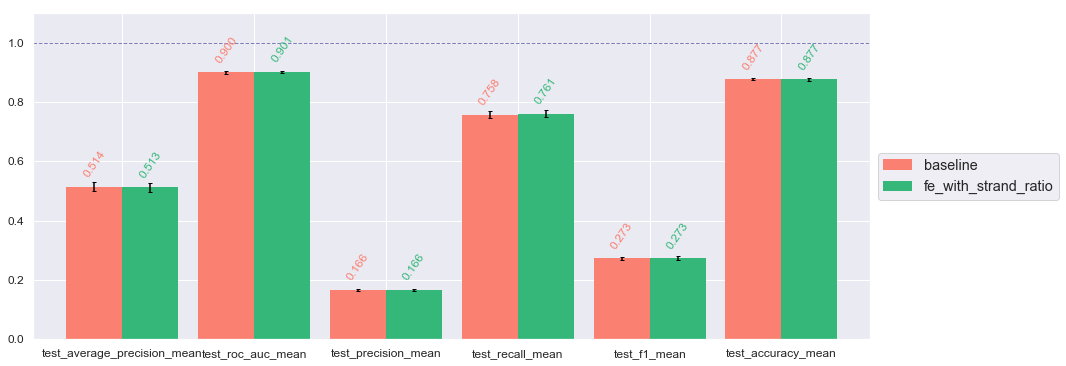

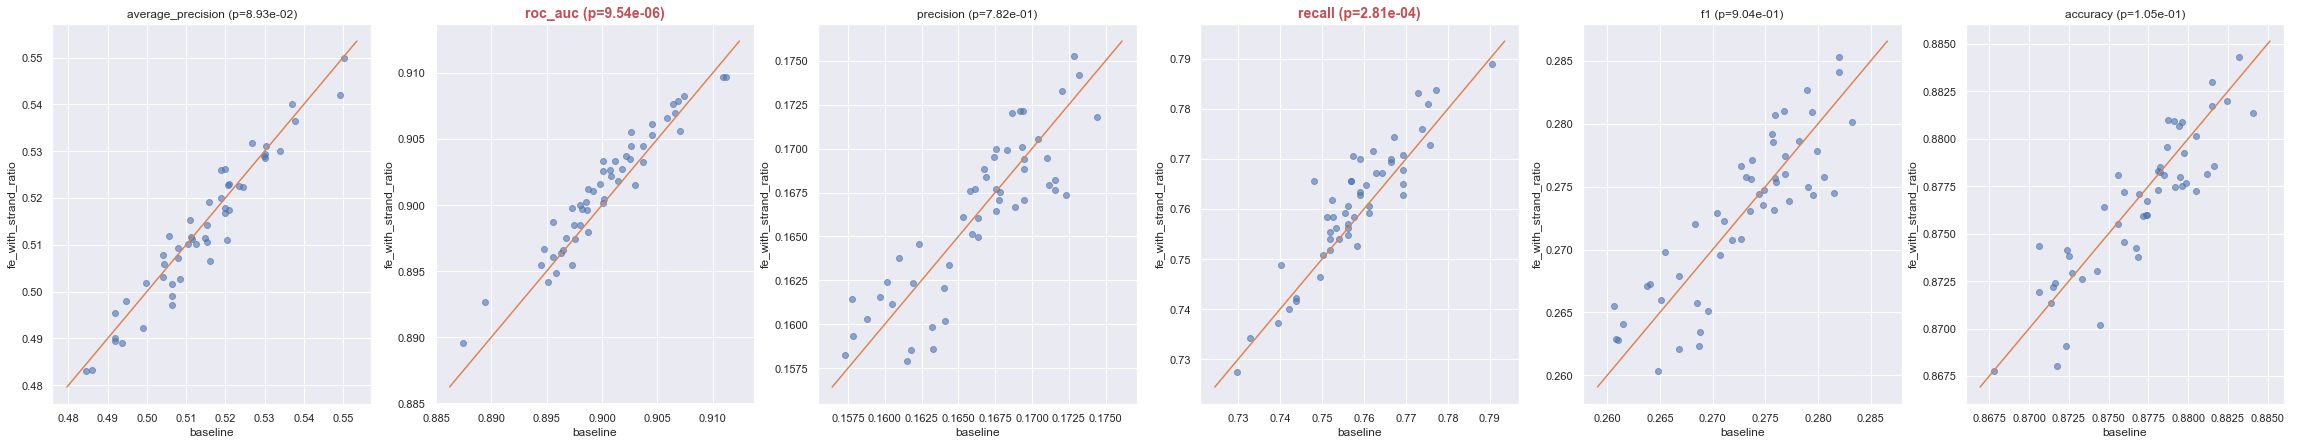

In [51]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## Event length

In [34]:
dd = abs(data.impact['Tumor_Seq_Allele2'].str.len() - data.impact['Reference_Allele'].str.len()) + 1
dd.head()

0     1
1     1
2     1
3     1
4    11
dtype: int64

In [35]:
data.add_features('event_length', dd, False)

In [36]:
features = get_features() + ['event_length']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_event_length')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_event_length >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_event_length


<span style="color:green">Job < ferf_with_event_length >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_event_length


<span style="color:green">Job < ferf_with_event_length >: </span>✅ script loaded

In [37]:
job = Selene_Job('ferf_with_event_length', load_from_id=True)

<span style="color:green">Job < ferf_with_event_length >: </span>✅ job found and reloaded

In [38]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_ferf_with_event_length to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_event_length
script.ipy                                    100%  862    62.9KB/s   00:00    
X.pkl                                         100%   74MB  15.6MB/s   00:04    
y.pkl                                         100% 3736KB  15.7MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_event_length
Job <30747981> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_event_length -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_event_length >: </span>✅ submitted<br>

In [39]:
job.get_results()

<span style="color:red">Job < ferf_with_event_length >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
fe_with_event_length,0.515,0.9,0.174,0.753,0.282,0.883


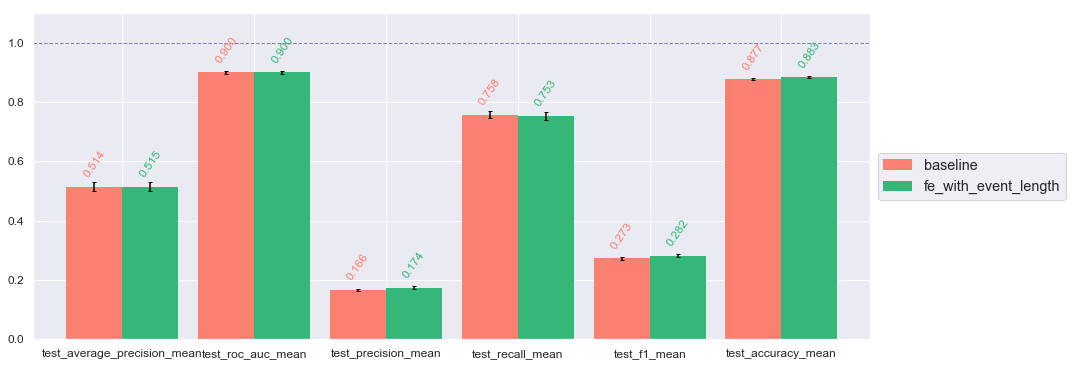

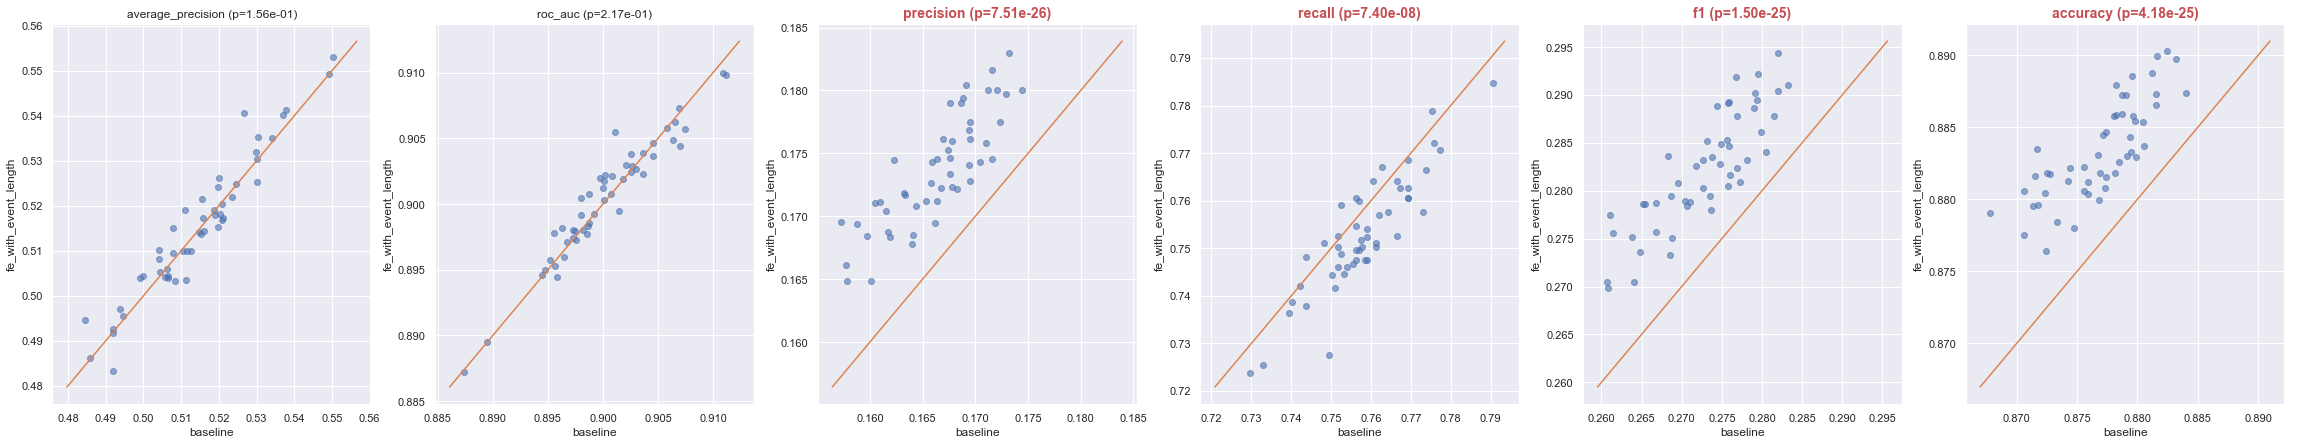

In [108]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## `variant_caller_cv`

In [40]:
features = get_features() + ['variant_caller_cv']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_variant_caller_cv')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_variant_caller_cv >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_variant_caller_cv


<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_variant_caller_cv


<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ script loaded

In [41]:
job = Selene_Job('ferf_with_variant_caller_cv', load_from_id=True)

<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ job found and reloaded

In [42]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_ferf_with_variant_caller_cv to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_variant_caller_cv
script.ipy                                    100%  862    79.4KB/s   00:00    
X.pkl                                         100%   75MB  13.1MB/s   00:05    
y.pkl                                         100% 3736KB  12.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_variant_caller_cv
Job <30748025> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_variant_caller_cv -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ submitted<br>

In [43]:
job.get_results()

<span style="color:red">Job < ferf_with_variant_caller_cv >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
fe_with_variant_caller_cv,0.563,0.93,0.197,0.817,0.318,0.893


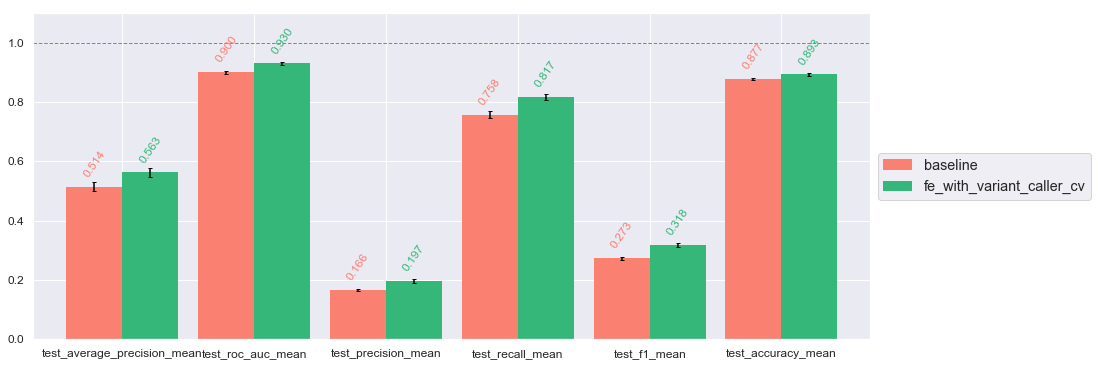

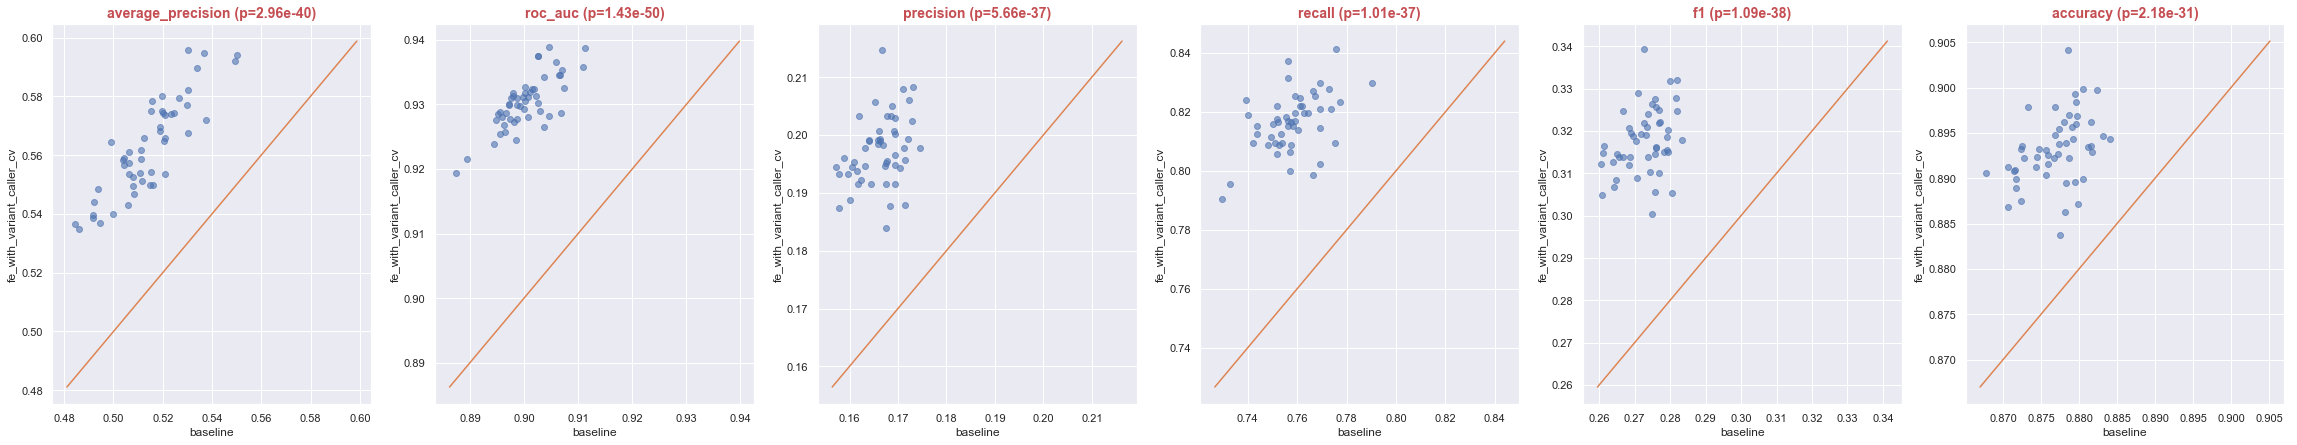

In [57]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## Base change (ex: C>T)

In [44]:
def switch_base(base):
    if base == 'G':
        return 'C'
    elif base == 'C':
        return 'G'
    elif base == 'A':
        return 'T'
    elif base == 'T':
        return 'A'

def get_base_change(mutation):
    if mutation['VEP_VARIANT_CLASS'] != 'SNV':
        return 'not_SNV'
    else:
        ref = mutation['Reference_Allele']
        alt = mutation['Tumor_Seq_Allele2']
        
        
        if mutation['Reference_Allele'] == 'G' or mutation['Reference_Allele'] == 'A' :
            ref = switch_base(ref)
            alt = switch_base(alt)
        
        return '{}>{}'.format(ref, alt)

    
dd = data.impact.apply(get_base_change, axis=1)
get_table(dd)

,count_,freq_
C>T,96828,43.03%
not_SNV,39650,17.62%
C>A,33491,14.88%
C>G,18708,8.31%
T>C,17808,7.91%
T>A,10598,4.71%
T>G,7939,3.53%


In [45]:
data.add_features('base_change', dd, True)

In [46]:
features = get_features() + ['base_change']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_base_change')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_base_change >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_base_change


<span style="color:green">Job < ferf_with_base_change >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_base_change


<span style="color:green">Job < ferf_with_base_change >: </span>✅ script loaded

In [47]:
job = Selene_Job('ferf_with_base_change', load_from_id=True)

<span style="color:green">Job < ferf_with_base_change >: </span>✅ job found and reloaded

In [48]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_ferf_with_base_change to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_base_change
script.ipy                                    100%  862   113.3KB/s   00:00    
X.pkl                                         100%   75MB  10.7MB/s   00:06    
y.pkl                                         100% 3736KB  11.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_base_change
Job <30748184> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_base_change -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_base_change >: </span>✅ submitted<br>

In [49]:
job.get_results()

<span style="color:red">Job < ferf_with_base_change >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
fe_with_base_change,0.517,0.905,0.158,0.775,0.262,0.867


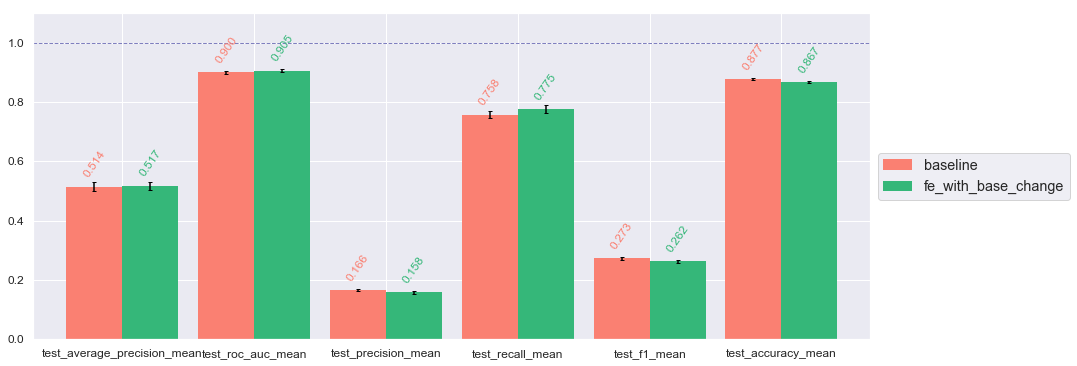

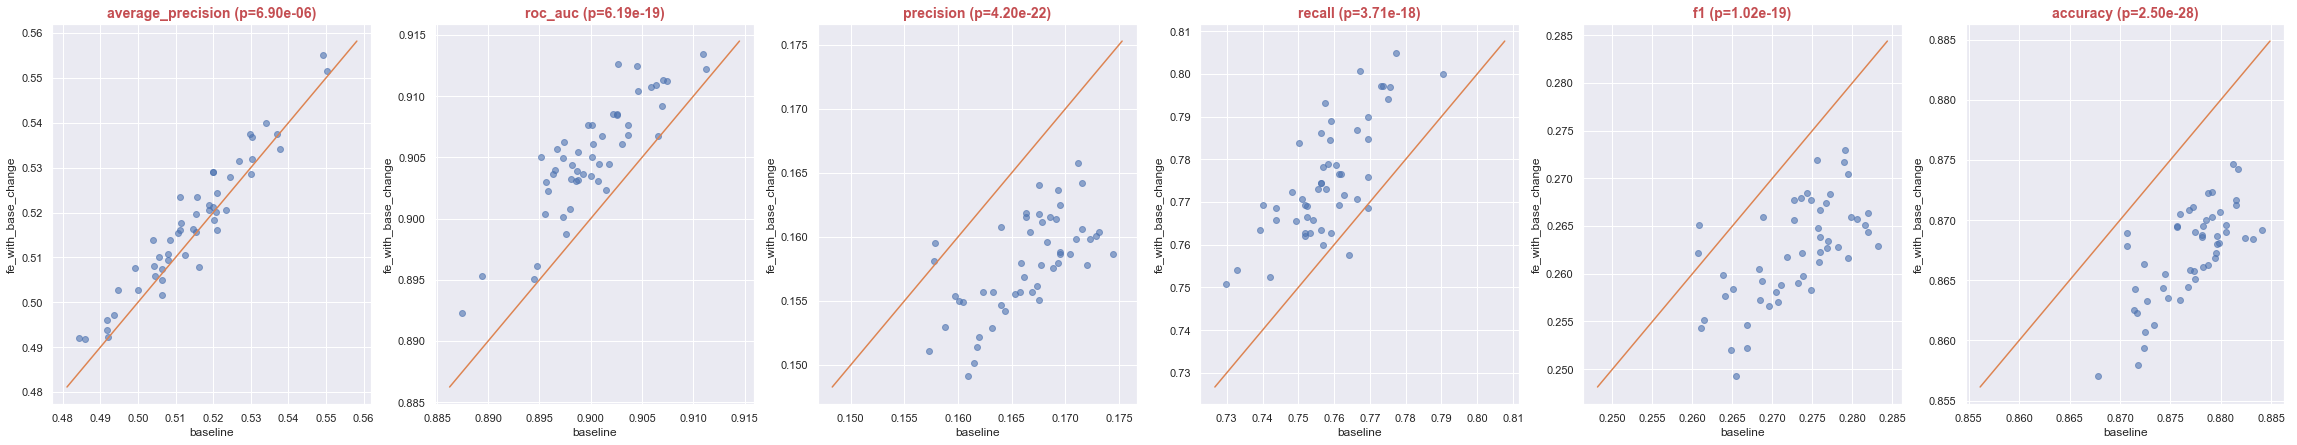

In [111]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## 3-base change (ex: ACT>AAT)

To run this part you need to download the reference fasta file from the cluster and to install pysam in your conda-env:
```bash
# get reference fasta file
$ scp guilminp@selene.mskcc.org:/ifs/work/leukgen/ref/homo_sapiens/GRCh37d5/genome/gr37.fasta temp/

# install pysam locally
$ source activate imp-ann_env
$ conda install pysam
```

In [50]:
from pysam import FastaFile
ref = FastaFile('../../../temp/gr37.fasta')

In [51]:
def switch_base(base):
    if base == 'G':
        return 'C'
    elif base == 'C':
        return 'G'
    elif base == 'A':
        return 'T'
    elif base == 'T':
        return 'A'

def get_base_at(chrom, position):
    return ref.fetch(reference = chrom, start = position - 1, end = position)

def get_3_base_change(mutation):
    if mutation['VEP_VARIANT_CLASS'] != 'SNV':
        return 'not_SNV'
    else:
        ref = mutation['Reference_Allele']
        alt = mutation['Tumor_Seq_Allele2']
        
        before = get_base_at(mutation['Chromosome'], mutation['Start_Position'] - 1)
        after  = get_base_at(mutation['Chromosome'], mutation['Start_Position'] + 1)
        if mutation['Reference_Allele'] == 'G' or mutation['Reference_Allele'] == 'A' :
            ref    = switch_base(ref)
            alt    = switch_base(alt)
            before = switch_base(before)
            after  = switch_base(after)
        
        return '{2}{0}{3}>{2}{1}{3}'.format(ref, alt, before, after)

In [52]:
dd = data.impact.apply(get_3_base_change, axis=1)
get_table(dd).head()
len(dd.unique()) # 96 + 1 for 'not_SNV'
len(get_table(dd).index) - 1

96

In [53]:
base_change_3_table = get_table(dd)
base_change_3_table = base_change_3_table[base_change_3_table['count_'] >= 2000]

def get_reduced_base_change_3(base_change_3):
    if base_change_3 in base_change_3_table.index:
        return base_change_3
    else:
        return 'other'

In [54]:
dd = dd.apply(get_reduced_base_change_3)
len(dd.unique())

28

In [55]:
data.add_features('3_base_change', dd, True)

In [56]:
data.impact[['Chromosome', 'Start_Position', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2', '3_base_change']].head(6)

,Chromosome,Start_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,3_base_change
0,4,106164779,SNP,G,A,GCT>GTT
1,19,2220185,SNP,G,T,other
2,7,128829128,SNP,G,A,GCC>GTC
3,9,87570204,SNP,C,G,other
4,3,142281824,INS,-,GCAGGACTCTT,not_SNV
5,2,220440222,SNP,C,A,TCT>TAT


In [57]:
features = get_features() + ['3_base_change']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_rf_with_3_base_change')
job.load_data(X, y, path_to_script=job_baseline.script_path)

➞ mkdir on local computer ssh_remote_jobs/job_fe_rf_with_3_base_change


<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_rf_with_3_base_change


<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_fe_rf_with_3_base_change


<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ script loaded

In [58]:
job = Selene_Job('fe_rf_with_3_base_change', load_from_id=True)

<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ job found and reloaded

In [59]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_fe_rf_with_3_base_change to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fe_rf_with_3_base_change
script.ipy                                    100%  862   129.8KB/s   00:00    
X.pkl                                         100%   75MB  12.6MB/s   00:05    
y.pkl                                         100% 3736KB  16.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_fe_rf_with_3_base_change
Job <30748393> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_rf_with_3_base_change -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ submitted<br>

In [60]:
job.get_results()

<span style="color:red">Job < fe_rf_with_3_base_change >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
fe_with_3_base_change,0.518,0.906,0.157,0.779,0.261,0.866


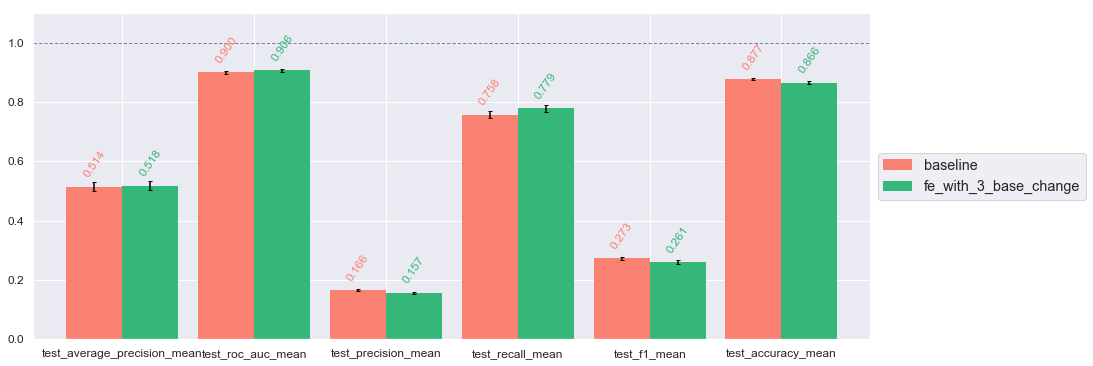

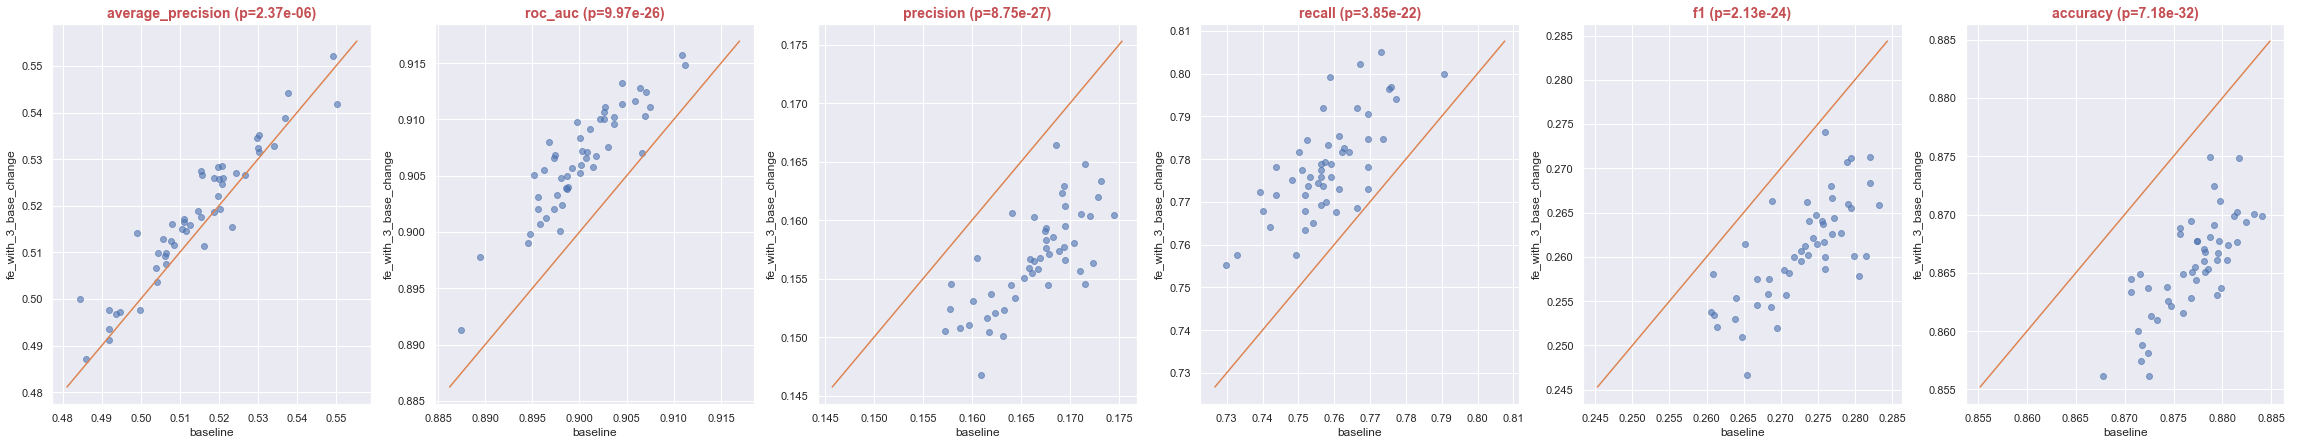

In [111]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## `VEP_SYMBOL`

In [61]:
gene_table = get_table(data.impact['VEP_SYMBOL'])
gene_table = gene_table[gene_table['count_'] >= 1000]

def get_reduced_gene(gene):
    if gene in gene_table.index:
        return gene
    else:
        return 'other'

dd = data.impact['VEP_SYMBOL'].apply(get_reduced_gene)
get_table(dd)

,count_,freq_
other,140954,62.64%
TP53,13139,5.84%
KRAS,4569,2.03%
PIK3CA,4470,1.99%
APC,4264,1.89%
KMT2D,3161,1.40%
ARID1A,3149,1.40%
PTEN,2470,1.10%
KMT2C,2214,0.98%
EGFR,2136,0.95%


In [62]:
data.add_features('reduced_gene', dd, True)

In [63]:
features = get_features() + ['reduced_gene']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_reduced_gene')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_reduced_gene >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_reduced_gene


<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_reduced_gene


<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ script loaded

In [64]:
job = Selene_Job('ferf_with_reduced_gene', load_from_id=True)

<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ job found and reloaded

In [65]:
job.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_ferf_with_reduced_gene to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_reduced_gene
script.ipy                                    100%  862    74.6KB/s   00:00    
X.pkl                                         100%   75MB  10.7MB/s   00:07    
y.pkl                                         100% 3736KB  11.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_ferf_with_reduced_gene
Job <30748555> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_reduced_gene -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ submitted<br>

In [66]:
job.get_results()

<span style="color:red">Job < ferf_with_reduced_gene >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.514,0.9,0.166,0.758,0.273,0.877
fe_with_reduced_gene,0.521,0.905,0.171,0.773,0.28,0.879


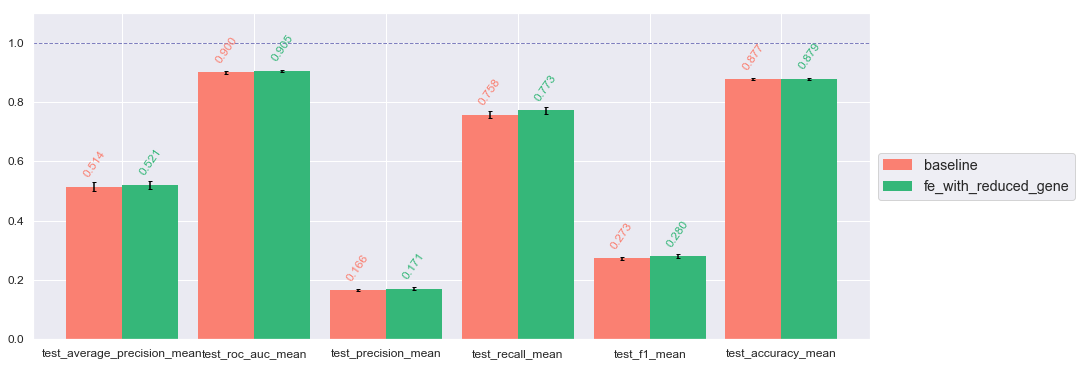

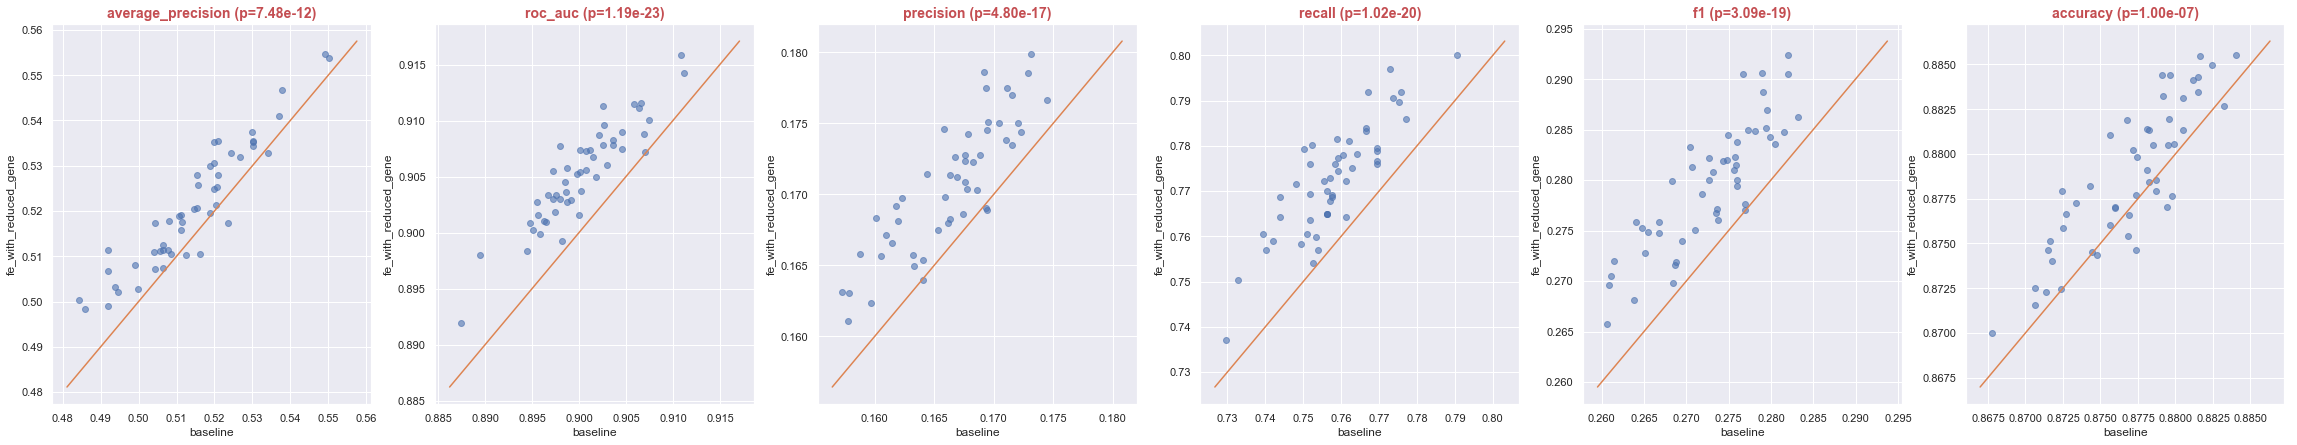

In [120]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

# Conclusion

The optimal set of features is:
